# **Brain Tumor Segmentation - Data Preprocessing**



### Mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Downloading required libraries

In [2]:
!pip install nibabel nilearn opendatasets split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.3 MB/s eta 0:00:00


In [3]:
%cd /content/

/content


### Downloading dataset

{"username":"arceus948","key":"f135ef59afbd96b23576bfdd1d01d598"}

In [4]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arceus948
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation


100%|██████████| 4.16G/4.16G [00:41<00:00, 107MB/s]


### Importing required libraries

In [5]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import os
from sklearn.preprocessing import MinMaxScaler
import random
import shutil
import splitfolders

## **PART - 1:**

All BraTS multimodal scans are available as NIfTI files (.nii) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings

1. T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

**Note: Segmented file name in Folder 355 has a weird name. Rename it to match others**

### Renaming incorrect files

In [6]:
TRAIN_DATASET_PATH = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [7]:
# Define the path to the directory containing the patient subfolders
base_path = TRAIN_DATASET_PATH

# Define the specific patient folder and the incorrect file name
patient_folder = 'BraTS20_Training_355'
incorrect_file_name = 'W39_1998.09.19_Segm.nii'
correct_file_name = 'BraTS20_Training_355_seg.nii'

# Full path to the incorrect file
incorrect_file_path = os.path.join(base_path, patient_folder, incorrect_file_name)

# Full path to the correct file
correct_file_path = os.path.join(base_path, patient_folder, correct_file_name)

# Check if the incorrect file exists
if os.path.exists(incorrect_file_path):
    # Rename the file
    os.rename(incorrect_file_path, correct_file_path)
    print(f"File renamed to: {correct_file_name}")
else:
    print(f"The file {incorrect_file_name} does not exist in the directory.")

File renamed to: BraTS20_Training_355_seg.nii


### Remove T1 modality from each folder in train data and also delete the validation folder

In [8]:
import os

# Define the path to the 'train' directory
train_dir = TRAIN_DATASET_PATH

# Walk through the subdirectories in 'train'
for root, dirs, files in os.walk(train_dir):
    for file in files:
        # Check if the file ends with 't1.nii.gz'
        if file.endswith('t1.nii'):
            # Construct the full file path
            file_path = os.path.join(root, file)
            # Delete the file
            os.remove(file_path)
print('Deleted all T1 modalities from train folder')

# Define the path to the 'validation' directory
validation_dir = '/content/brats20-dataset-training-validation/BraTS2020_ValidationData'

# Remove the entire directory
shutil.rmtree(validation_dir)
print(f'Deleted the validation folder')

Deleted all T1 modalities from train folder
Deleted the validation folder


### Compressing train folder files to save space

In [9]:
# Define the path to the dataset
base_path = TRAIN_DATASET_PATH  # Update this to your dataset path

# Walk through the directory
for root, dirs, files in os.walk(base_path):
    for file in files:
        # Check if the file is a '.nii' file
        if file.endswith('.nii'):
            file_path = os.path.join(root, file)
            # Load the image file
            image = nib.load(file_path)
            # Define the new file name with '.nii.gz' extension
            gz_file_path = file_path + '.gz'
            # Save the file in compressed '.nii.gz' format
            nib.save(image, gz_file_path)
            # Remove the original '.nii' file
            os.remove(file_path)
            # print(f"Converted and replaced {file} with {os.path.basename(gz_file_path)}")

print("Train Dataset Compression complete.")

Train Dataset Compression complete.


### Normalization and Datatype conversion


In [10]:
test_image_flair=nib.load(TRAIN_DATASET_PATH+'/BraTS20_Training_355/BraTS20_Training_355_flair.nii.gz').get_fdata()
print(test_image_flair.max())

# Here our dataset is not normalized so we normalize it

1854.603271484375


In [11]:
# Define the path to the dataset
base_path = TRAIN_DATASET_PATH  # Make sure this is defined correctly

# Initialize the scaler
scaler = MinMaxScaler()

# Get a list of all subfolders in the base path
subfolders = [f.path for f in os.scandir(base_path) if f.is_dir()]

# Iterate over the patient folders
for patient_folder_path in subfolders:
    patient_id = os.path.basename(patient_folder_path)

    # Define the modalities
    modalities = ['flair', 't1ce', 't2', 'seg']

    # Process each modality
    for modality in modalities:
        file_name = f"{patient_id}_{modality}.nii.gz"  # Working with .nii.gz files
        file_path = os.path.join(patient_folder_path, file_name)

        # Check if the file exists before processing
        if os.path.exists(file_path):
            # Load the image data
            image = nib.load(file_path)
            image_data = image.get_fdata(dtype=np.float32)

            # If it's not the segmentation mask, apply scaling
            if modality != 'seg':
                # Reshape, scale, and reshape back to original shape
                image_data = scaler.fit_transform(image_data.reshape(-1, image_data.shape[-1])).reshape(image_data.shape)
            else:
                # For segmentation mask, convert to uint8 and reassign label values
                image_data = image_data.astype(np.uint8)
                image_data[image_data == 4] = 3  # Reassign mask values 4 to 3

            # Save the processed data to a new .nii.gz file
            nib.save(nib.Nifti1Image(image_data, image.affine), file_path)

print("All patient folders have been processed and normalized.")

All patient folders have been processed and normalized.


In [15]:
test_image_flair=nib.load(TRAIN_DATASET_PATH+'/BraTS20_Training_355/BraTS20_Training_355_flair.nii.gz').get_fdata()
print(test_image_flair.max())

test_image_t2=nib.load(TRAIN_DATASET_PATH+'/BraTS20_Training_355/BraTS20_Training_355_t2.nii.gz').get_fdata()
print(test_image_t2.max())

test_image_t1ce=nib.load(TRAIN_DATASET_PATH+'/BraTS20_Training_355/BraTS20_Training_355_t1ce.nii.gz').get_fdata()
print(test_image_t1ce.max())

test_image_seg=nib.load(TRAIN_DATASET_PATH+'/BraTS20_Training_355/BraTS20_Training_355_seg.nii.gz').get_fdata()
print(test_image_seg.max())

# Here our dataset is normalized

1.0
1.0
1.0
3.0


### Displaying the images from train dataset

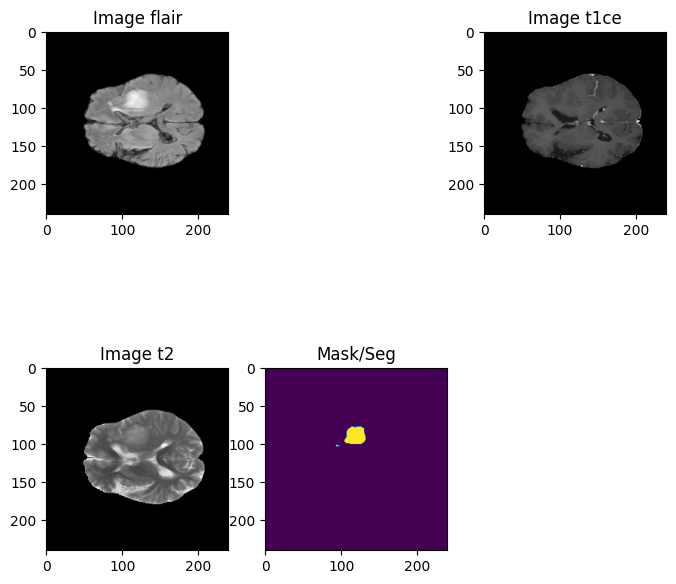

In [19]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii.gz').get_fdata()

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii.gz').get_fdata()

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii.gz').get_fdata()

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii.gz').get_fdata()

n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(8, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')

plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')

plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')

plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask/Seg')

plt.show()

## **PART 2:**
Explore the process of combining images to channels and divide them to patches.

Combining all 4 images to 4 channels of a numpy array.
Flair, T1CE, annd T2 have the most information



### Combining + Cropping + Saving

Combine T1CE, T2, FLAIR into one file and save as npy format and also save the SEGMENTED file into npy format. Save the combined images in images folder and segmented images in masks folder

In [20]:
# Base directory for training data
TRAIN_DATA_DIR = TRAIN_DATASET_PATH

# New directories for saving processed images and masks
PROCESSED_IMAGE_DIR = os.path.join('BraTS-2020', 'images')
PROCESSED_MASK_DIR = os.path.join('BraTS-2020', 'masks')

# Create directories if they do not exist
os.makedirs(PROCESSED_IMAGE_DIR, exist_ok=True)
os.makedirs(PROCESSED_MASK_DIR, exist_ok=True)

# List of patient folder names
patient_folders = [f for f in os.listdir(TRAIN_DATA_DIR) if os.path.isdir(os.path.join(TRAIN_DATA_DIR, f))]

# Loop through each patient folder
for patient_folder in patient_folders:
    patient_path = os.path.join(TRAIN_DATA_DIR, patient_folder)

    # Load the modalities
    image_flair = nib.load(os.path.join(patient_path, patient_folder + '_flair.nii.gz')).get_fdata()
    image_t1ce = nib.load(os.path.join(patient_path, patient_folder + '_t1ce.nii.gz')).get_fdata()
    image_t2 = nib.load(os.path.join(patient_path, patient_folder + '_t2.nii.gz')).get_fdata()

    # Load the mask
    mask = nib.load(os.path.join(patient_path, patient_folder + '_seg.nii.gz')).get_fdata()

    # Combine the images into a single array
    combined_images = np.stack([image_flair, image_t1ce, image_t2], axis=3)

    # Crop the images and mask
    combined_images = combined_images[56:184, 56:184, 13:141]
    mask = mask[56:184, 56:184, 13:141]

    # Check if the mask has at least 1% non-zero labels
    val, counts = np.unique(mask, return_counts=True)
    if (1 - (counts[0]/counts.sum())) > 0.01:
        mask = to_categorical(mask, num_classes=4)

        # Save the combined images and mask with new names in the respective directories
        combined_image_path = os.path.join(PROCESSED_IMAGE_DIR, patient_folder + '.npy')
        mask_path = os.path.join(PROCESSED_MASK_DIR, patient_folder + '_seg.npy')
        np.save(combined_image_path, combined_images)
        np.save(mask_path, mask)

    else:
        print(f"Patient {patient_folder} data is not useful")

# Delete the TRAIN_DATA_DIR after processing all patient folders
# Path to the folder you want to delete
folder_path = '/content/brats20-dataset-training-validation'

# Use try-except block to handle potential errors
try:
    # Remove the entire directory tree
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Patient BraTS20_Training_044 data is not useful
Patient BraTS20_Training_139 data is not useful
Patient BraTS20_Training_325 data is not useful
Patient BraTS20_Training_063 data is not useful
Patient BraTS20_Training_099 data is not useful
Patient BraTS20_Training_122 data is not useful
Patient BraTS20_Training_036 data is not useful
Patient BraTS20_Training_028 data is not useful
Patient BraTS20_Training_177 data is not useful
Patient BraTS20_Training_061 data is not useful
Patient BraTS20_Training_204 data is not useful
Patient BraTS20_Training_108 data is not useful
Patient BraTS20_Training_341 data is not useful
Patient BraTS20_Training_314 data is not useful
Patient BraTS20_Training_268 data is not useful
Patient BraTS20_Training_086 data is not useful
Patient BraTS20_Training_142 data is not useful
Patient BraTS20_Training_233 data is not useful
Patient BraTS20_Training_082 data is not useful
Patient BraTS20_Training_217 data is not useful
Patient BraTS20_Training_110 data is not

## **PART - 3:**
### Split train dataset into train and validation folder using **splitfolder** library

In [22]:
# Define the input and output paths
input_folder = '/content/BraTS-2020'
output_folder = '/content/BraTS-2020'

# Split the dataset into training and validation sets with a ratio of 80:20
# and move the files to the respective folders
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2), move=True)

# Remove the original images and masks folders after moving the files
os.rmdir(os.path.join(input_folder, 'images'))
os.rmdir(os.path.join(input_folder, 'masks'))

print('Dataset successfully split and original folders removed.')


Copying files: 688 files [00:00, 6158.85 files/s]

Dataset successfully split into training and validation sets.
